## Bayesian Hyper-Parameter Optimization: Neural Network Model in TensorFlow, Facies Prediction Example
#### _[Ryan A. Mardani](https://www.linkedin.com/in/amardani/)_

The purpose of this project is to optimize the neural network model hyper-parameters to estimate facies class from well logs.<br>
In machine learning, model parameters can be divided into two main categories:<br>
1- __Trainable parameters__: such as weights in neural networks learned by training algorithms and the user does not interfere in the process,<br>
2- __Hyper-parameters__ that user can set before training operation such as learning rate or the number of dense layers in the model.<br>
Selecting the best hyper-parameters can be a tedious task if you do it by hand and it is almost impossible to find the best ones if you are dealing with more than two parameters. <br>
One way is to divide each parameter into a valid evenly range and then simply ask the computer to loop for the combination of parameters and calculate the results. The method is called Grid Search. Although it is done by machine, it will be a time-consuming process. Suppose you have 3 hyper-parameters with 10 possible values in each. In this approach, you will run 10^3 neural network models (even with reasonable training datasets size, this task is huge).<br>
Another way is a random search approach. In fact, instead of using organized parameter searching, it will go through a random combination of parameters and look for the optimized ones. You may estimate that chance of success decreases to zero for larger hyper-parameter tunings.
 

__Scikit-Optimize__, skopt, which we will use here to the facies estimation task, is a simple and efficient library to minimize expensive noisy black-box functions. Bayesian optimization constructs another model of search-space for parameters. Gaussian Process is one kind of these models. This generates an estimate of how model performance varies with hyper-parameter changes.<br>
As we see in the picture, the true objective function(red dash line) is surrounded by noise (red shade). The red line shows how scikit optimize sampled the search space for hyper-parameters(one dimension). Scikit-optimize fills the area between sample points with the Gaussian process (green line) and estimates true real fitness value. In the areas with low samples or lack(like the left side of the picture between two red samples), there is great uncertainty (big diffrence between red and green lines causing big uncertainty green shade area such as two standard deviation).<br> 
In this process, then we ask a new set of hyper-parameter to explore more search space. In the initial steps, it goes with sparse accuracy but later iterations, it focuses on where sampling points are more with good agreement of fitness function with true objective function(trough area in graph).<br>
For more study, you may refer to Scikit Optimize [documentation](https://scikit-optimize.github.io/stable/user_guide.html).

![Hyper-Parameter](Bays_Opt.png)


### Imports for Neural Network with Keras

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

### Imports for Scikit Optimizer

In [2]:
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

### Data Review

The Council Grove gas reservoir is located in Kansas. From this carbonate reservoir, nine wells are avaialble. Facies are stduied from core samples in every half foot and matched with logging data in well location. Feature variables include five from wireline log measurements and two geologic constraining variables that are derived from geologic knowledge. For more detail refer [here](https://github.com/mardani72/Facies-Classification-Machine-Learning/blob/master/Facies_Classification_Various_ML_Final.ipynb).
For dataset, you may download from [here](https://github.com/mardani72/Facies-Classification-Machine-Learning/blob/master/training_data.csv).
The seven variables are:<br>
1. __GR__: this wireline logging tools measure gamma emission from formation. Good index for shale content.<br>
2. __ILD_log10__ : this is resistivity measurment which is applicable for identification of reservoir fluid content.<br>
3. __PE__ : photoelectric effect log can be used for lithology (mineral contet of rock) identificaiton.<br>
4. __DeltaPHI__: Phi is porosity index in petrophysics. To measure porosity, there serval methods such as neutron and density. This is differences between them.<br>
5. __PNHIND__: Average of neutron and density log.<br>
6. __NM_M__ :nonmarine-marine indicator<br>
7. __RELPOS__: relative position<br>

The nine discrete facies (classes of rocks) are: 
1. __(SS)__   Nonmarine sandstone 
2. __(CSiS)__ Nonmarine coarse siltstone
3. __(FSiS)__ Nonmarine fine siltstone 
4. __(SiSH)__ Marine siltstone and shale 
5. __(MS)__   Mudstone (limestone) 
6. __(WS)__   Wackestone (limestone)
7. __(D)__    Dolomite
8. __(PS)__   Packstone-grainstone (limestone)
9. __(BS)__   Phylloid-algal bafflestone (limestone) 
 

In [3]:
df = pd.read_csv('training_data.csv')

In [4]:
# specify some data types may python concern about
df['Facies'] = df['Facies'].astype('int')
df['Depth'] = df['Depth'].astype('float')
df['Well Name'] = df['Well Name'].astype('category')
df['Formation'] = df['Formation'].astype('category')

### Log plot

In [5]:
# colors 
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00',
       '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

facies_labels = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS',
                 'WS', 'D','PS', 'BS']
#facies_color_map is a dictionary that maps facies labels to their respective colors
facies_color_map = {}
for ind, label in enumerate(facies_labels):
    facies_color_map[label] = facies_colors[ind]

def label_facies(row, labels):
    return labels[ row['Facies'] -1]
#establish facies label str    
df.loc[:,'FaciesLabels'] = df.apply(lambda row: label_facies(row, facies_labels), axis=1)

Pick up a well as blind: machine learning algorithm will not see this data in the training process. We will use it at the end to see how the model works. Remember to select a well that includes all types of facies classes, otherwise in prediction, data dimension inconsistency will generate an error. Or simply add a lacking facies example to the well to avoid the problem.

In [6]:
blind = df[df['Well Name'] == 'SHANKLE']
training_data = df[df['Well Name'] != 'SHANKLE']

This is function to create a plot.

In [7]:
def make_facies_log_plot(logs, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster=np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=6, figsize=(12, 6))
    ax[0].plot(logs.GR, logs.Depth, '-g',  alpha=0.8, lw = 0.9)
    ax[1].plot(logs.ILD_log10, logs.Depth, '-b',  alpha=0.8, lw = 0.9)
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-k',  alpha=0.8, lw = 0.9)
    ax[3].plot(logs.PHIND, logs.Depth, '-r',  alpha=0.8, lw = 0.9)
    ax[4].plot(logs.PE, logs.Depth, '-c',  alpha=0.8, lw = 0.9)
    im=ax[5].imshow(cluster, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[5])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im, cax=cax)
    cbar.set_label((5*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-1):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([])
    ax[5].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

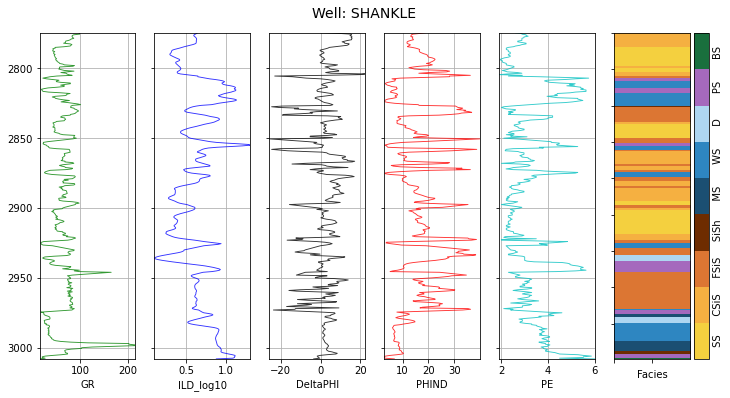

In [8]:
make_facies_log_plot(
    training_data[training_data['Well Name'] == 'SHANKLE'],
    facies_colors)
# plt.savefig("Compo.png", dpi=400)

### Feature Engineering

Facies classes should be converted to dummy variable in order to use in neural network

In [9]:
dummies = pd.get_dummies(training_data['FaciesLabels'])                        
Facies_cat = dummies.columns
labels = dummies.values # target matirx

In [10]:
# select predictors
features = training_data.drop(['Facies', 'Formation', 'Well Name', 
                               'Depth','FaciesLabels'], axis=1)

#### Preprocessing (make standard)

As we are dealing with various range of data, to make network efficient, let's normalize it.

In [11]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(features)
scaled_features = scaler.transform(features)

#### Data split

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        scaled_features, labels, test_size=0.2, random_state=42)

## Hyper-Parameters

In this work, we will predict facies from well logs using deep learning in Tensorflow. There several hyper-parameters that we may adjuct for deep learning. I will try to find out the optimized prameters for:
1. _Learning rate_
2. _Number of dense layers_
3. _Number of nodes for each layers_
4. _Which activation function: 'relu' or sigmoid_ 

To elaborate in this search dimension, we will use scikit-optimize(skopt) library 

From skopt, real function will define our favorate range(lower bound = 1e-6, higher bound = 1e-1) for learning rate and will use logarithmic transformation.

In [13]:
dim_learning_rate = Real(low=1e-6, high=1e-1, prior='log-uniform',
                         name='learning_rate')

The search dimension for number of layers (we look between 1 to 5) and each layer's node amounts(between 5 to 512) can be implemented with Integer function of skopt.

In [14]:
dim_num_dense_layers = Integer(low=1, high=10, name='num_dense_layers')

In [15]:
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')

For activation algorithms, we should use categorical function for optimization.

In [16]:
dim_activation = Categorical(categories=['relu', 'sigmoid'],
                             name='activation')

Bring all search-dimensions into a single list:

In [17]:
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation]

If you already worked with deep learning for specific project and found your hyper-parameters by hand for that project, you know that how hard it is to optimize. You may also use your own guess (like mine as default) to compare the results with Bayesian tuning approach.

In [18]:
default_parameters = [1e-5, 1, 16, 'relu']

In [19]:
# This is a function to log traning progress so that can be viewed by TnesorBoard.
def log_dir_name(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation)

    return log_dir

## Hyper-Parameter Optimization
#### Create Model 

Like some examples developed by Tneseflow, we also need to define a model function first. After defining type of model(Sequential here), we need to introduce data dimension (data shape) in the first line. Number of layers and activation types are those two hyper-parameters that we are looking for to optimize. Softmax activation should be used for classification probelems. Then another hyper-parameter is learning rate which should be defined in the Adam function. 
Model should be compiled considering that loss function should be 'categorical_crossentropy' as we are dealing with classification problem (facies prediction).

In [20]:
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation):
    
    model = Sequential()

    model.add(InputLayer(input_shape=(scaled_features.shape[1])))
    
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)

        # add dense layer
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # use softmax-activation for classification.
    model.add(Dense(labels.shape[1], activation='softmax'))
    
    # Use the Adam method for training the network.
    optimizer = Adam(lr=learning_rate)
    
    #compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

#### Train and Evaluate the Model

To use the best model saved to disk which contains optmized hyper-paramter,  we can give the path for the model name:

In [21]:
path_best_model = '19_best_model.h5'

In [22]:
#define global variable to store accuracy
best_accuracy = 0.0

In [23]:
validation_data = (X_test, y_test)

This function aims to create and train a network with given hyper-parameters and then evaluate model performance with the validation dataset. It returns fitness value, negative classification accuracy on the dataset. It is negative because skpot performs minimization rather than maximization.

In [24]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.
    callback_log = TensorBoard(
        log_dir=log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=False,
        write_images=False)
   
    # Use Keras to train the model.
    history = model.fit(x= X_train,
                        y= y_train,
                        epochs=3,
                        batch_size=128,
                        validation_data=validation_data,
                        callbacks=[callback_log])

    # Get the classification accuracy on the validation-set
    # after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy
# This function exactly comes from :Hvass-Labs, TensorFlow-Tutorials

In [25]:
#Test with dafault parameters
fitness(x= default_parameters)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
18/18 [==============================] - 2s 84ms/step - loss: 2.2555 - accuracy: 0.1413 - val_loss: 2.2515 - val_accuracy: 0.1083
Epoch 2/3
18/18 [==============================] - 0s 26ms/step - loss: 2.2539 - accuracy: 0.1413 - val_loss: 2.2500 - val_accuracy: 0.1083
Epoch 3/3
18/18 [==============================] - 0s 20ms/step - loss: 2.2523 - accuracy: 0.1418 - val_loss: 2.2484 - val_accuracy: 0.1101

Accuracy: 11.01%



-0.11010830104351044

### Run Hyper-Parameter Optimization

We already checked the default hyper-parameter performance. Now we can examine Bayesian optimization from schikit-optimize library. Here we use 40 runs for fitness function, though it is an expensive operation and needs to used carefully with datasets.

In [26]:
%%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)
# you may examine other kind of minimization
# search_result = forest_minimize(func=fitness,
#                             dimensions=dimensions,
#                             base_estimator='RF', 
#                             n_calls=50,
#                             random_state=4)

learning rate: 1.0e-05
num_dense_layers: 1
num_dense_nodes: 16
activation: relu

Epoch 1/3
18/18 [==============================] - 1s 59ms/step - loss: 2.6036 - accuracy: 0.0348 - val_loss: 2.5710 - val_accuracy: 0.0415
Epoch 2/3
18/18 [==============================] - 0s 15ms/step - loss: 2.6017 - accuracy: 0.0352 - val_loss: 2.5693 - val_accuracy: 0.0415
Epoch 3/3
18/18 [==============================] - 0s 15ms/step - loss: 2.6000 - accuracy: 0.0352 - val_loss: 2.5676 - val_accuracy: 0.0415

Accuracy: 4.15%

learning rate: 1.0e-02
num_dense_layers: 7
num_dense_nodes: 23
activation: relu

Epoch 1/3
18/18 [==============================] - 1s 64ms/step - loss: 1.7278 - accuracy: 0.3264 - val_loss: 1.1770 - val_accuracy: 0.4729
Epoch 2/3
18/18 [==============================] - 1s 40ms/step - loss: 1.0560 - accuracy: 0.5652 - val_loss: 0.9704 - val_accuracy: 0.6011
Epoch 3/3
18/18 [==============================] - 0s 18ms/step - loss: 0.9403 - accuracy: 0.6108 - val_loss: 0.8103 - v

### Progress visualization

Using plot_convergence function of skopt, we may see the optimization progress and the best fitness value found on y-axis.

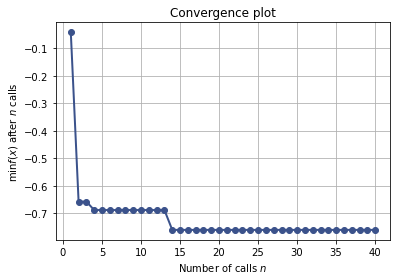

In [56]:
plot_convergence(search_result) 
# plt.savefig("Converge.png", dpi=400)

### Optimal Hyper-Parameters

Using serach_result function, we can see the best hyper-parameter that Bayesian-opitimzer generated.

In [28]:
search_result.x

[0.0034245387775643627, 6, 327, 'relu']

Optmized hyper-parematers are in order: Learning rate, number of dense layers, number of nodes in each layer and the best activation function.

In [29]:
# The best fitness value associated with these hyper-parameters
search_result.fun

-0.7599278092384338

We can see all results for 40 calls with corresponding hyper-parameters and fitness values.

In [30]:
sorted(zip(search_result.func_vals, search_result.x_iters))

[(-0.7599278092384338, [0.0034245387775643627, 6, 327, 'relu']),
 (-0.750902533531189, [0.0014165817852707162, 5, 429, 'relu']),
 (-0.743682324886322, [0.003081724901299357, 7, 319, 'relu']),
 (-0.7400721907615662, [0.0029160561740584957, 6, 380, 'relu']),
 (-0.7382671236991882, [0.00256162919296005, 6, 356, 'relu']),
 (-0.7346570491790771, [0.0017621039004493337, 5, 452, 'relu']),
 (-0.7310469150543213, [0.0031393613143477534, 6, 403, 'relu']),
 (-0.7292418479919434, [0.0016833818926714217, 6, 414, 'relu']),
 (-0.7256317734718323, [0.0018274838987705473, 6, 404, 'relu']),
 (-0.7256317734718323, [0.0031732854966821616, 6, 318, 'relu']),
 (-0.7220216393470764, [0.002810131903629435, 6, 399, 'relu']),
 (-0.7184115648269653, [0.0014149424264653355, 5, 416, 'relu']),
 (-0.7184115648269653, [0.003054435315051851, 1, 336, 'relu']),
 (-0.7184115648269653, [0.0033829776196947986, 1, 364, 'relu']),
 (-0.7148014307022095, [0.0036900921722258654, 5, 447, 'relu']),
 (-0.7075812220573425, [0.002938

## Plots

First, let's look at 2D plot of two optimized parameters. Here we made landscape-plot of estimated fitness values for learning rate and number of nodes in each layer.<br>
The Bayesian optimizer builds a surrogate model of search space and searches inside this dimension rather than real search-space, that is why it is faster. In the plot, the yellow regions are better and blue regions are worse. Balck dots are the optimizer's sampling location and the red star is the best parameter found.

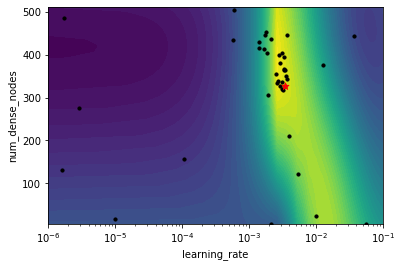

In [57]:
from skopt.plots import plot_objective_2D
fig = plot_objective_2D(result=search_result,
                        dimension_identifier1='learning_rate',
                        dimension_identifier2='num_dense_nodes',
                        levels=50)
# plt.savefig("Lr_numnods.png", dpi=400)

__Some points:__<br>
1. The surrogate model can be inaccurate because it is built from only 40 samples of calls to the fitness function
2. The plot may change in each time of optimization re-run because of random noise and training process in NN
3. This is 2D plot, while we optimized 4 parameters and could be imagined 4 dimensions.


In [32]:
# create a list for plotting
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation' ]

ValueError: too many values to unpack (expected 2)

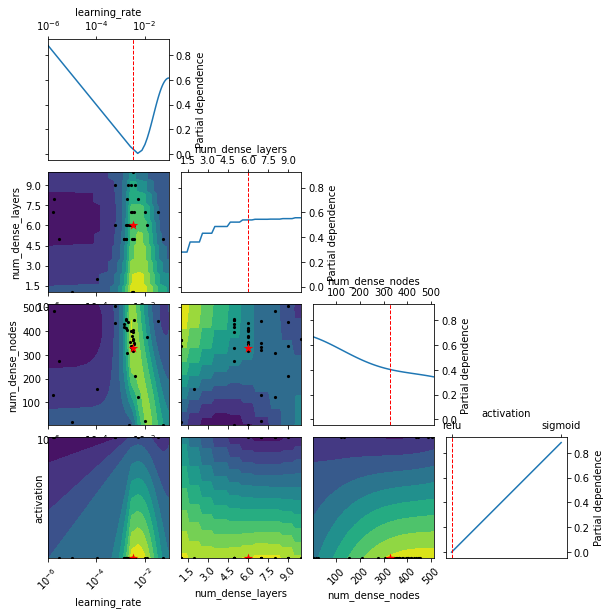

In [58]:
fig, ax = plot_objective(result=search_result, dimensions=dim_names)
plt.savefig("all_dimen.png", dpi=400)

In this plots we can see how the optimization happened. Bayesian approach tries to fit model parameters with prior info that at the points with higher density of sampling.<br>
note: the error that it 'can not unpack too many parameters', could not be solved. As skopt is newly developed, it may back to some internal problems.

ValueError: too many values to unpack (expected 2)

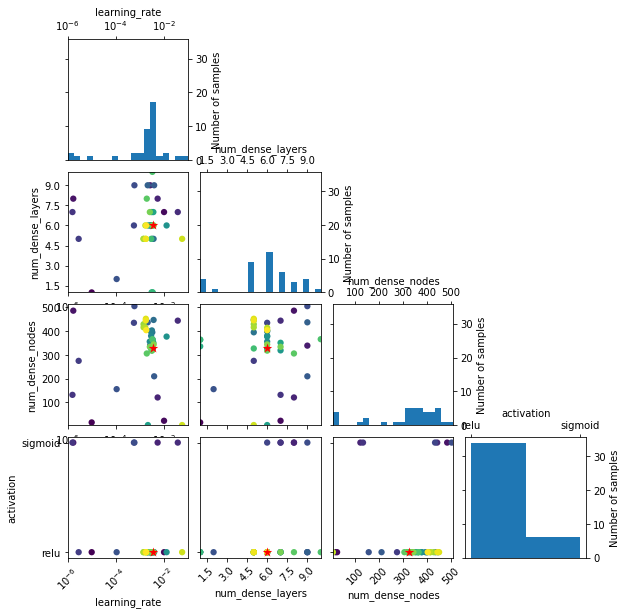

In [34]:
fig, ax = plot_evaluations(result=search_result, dimensions=dim_names)

This is another type of matrix-plot. The diagonal shows histograms of the sample distributions for each of the hyper-parameters during the Bayesian optimization. The plots show the location of samples in the search-space and the colour-coding shows the order in which the samples were taken. For larger numbers of samples you will likely see that the samples eventually become concentrated in a certain region of the search-space.

## Evaluate the model with optimized hyper-parameters with blind data

This capability of Keras is amazing. It is easy to call the best model stored in the disk:

In [35]:
best_model= load_model(path_best_model)

Do the same data preparation steps for the blind well dataset:

In [36]:
# dataset.replace(convert_nums, inplace=True)
dummies_blind = pd.get_dummies(blind['FaciesLabels'])                        
Facies_cat_b = dummies_blind.columns
labels_blind = dummies_blind.values

In [37]:
features_blind = blind.drop(['Facies', 'Formation', 'Well Name', 
                             'Depth','FaciesLabels'], axis=1)

In [38]:
scaler = preprocessing.StandardScaler().fit(features_blind)
scaled_features_blind = scaler.transform(features_blind)

Altough we already generated optimized model, it was based on small batch data size with 3 iteration. We can consrtuct full model with optimized hyper-parameters. 

In [39]:
opt_par = search_result.x

In [40]:
# use hyper-parameters from optimization
learning_rate = opt_par[0]
num_layers = opt_par[1]
num_nodes = opt_par[2]
activation = opt_par[3]

In [41]:
# Classification neural network
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(InputLayer(input_shape=(scaled_features.shape[1])))
model.add(Dense(num_nodes, activation=activation, kernel_initializer='random_normal'))
model.add(Dense(labels.shape[1], activation='softmax', kernel_initializer='random_normal'))

optimizer = Adam(lr=learning_rate)
    
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=['accuracy'])


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
                        verbose=1, mode='auto', restore_best_weights=True)

histories = model.fit(X_train,y_train, validation_data=(X_test,y_test),
          callbacks=[monitor],verbose=2,epochs=100)


Epoch 1/100
70/70 - 1s - loss: 1.1403 - accuracy: 0.6032 - val_loss: 0.7817 - val_accuracy: 0.7004
Epoch 2/100
70/70 - 1s - loss: 0.7506 - accuracy: 0.7052 - val_loss: 0.7345 - val_accuracy: 0.7112
Epoch 3/100
70/70 - 0s - loss: 0.6840 - accuracy: 0.7445 - val_loss: 0.6581 - val_accuracy: 0.7563
Epoch 4/100
70/70 - 1s - loss: 0.6531 - accuracy: 0.7485 - val_loss: 0.6265 - val_accuracy: 0.7599
Epoch 5/100
70/70 - 1s - loss: 0.6181 - accuracy: 0.7639 - val_loss: 0.6127 - val_accuracy: 0.7635
Epoch 6/100
70/70 - 0s - loss: 0.6061 - accuracy: 0.7652 - val_loss: 0.6091 - val_accuracy: 0.7708
Epoch 7/100
70/70 - 1s - loss: 0.5902 - accuracy: 0.7734 - val_loss: 0.6450 - val_accuracy: 0.7383
Epoch 8/100
70/70 - 1s - loss: 0.5783 - accuracy: 0.7716 - val_loss: 0.6371 - val_accuracy: 0.7599
Epoch 9/100
70/70 - 0s - loss: 0.5690 - accuracy: 0.7833 - val_loss: 0.6372 - val_accuracy: 0.7599
Epoch 10/100
70/70 - 1s - loss: 0.5516 - accuracy: 0.7964 - val_loss: 0.6199 - val_accuracy: 0.7545
Epoch 11/

In [42]:
print(histories.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [43]:
# import tensorflow_docs as tfdocs
# import tensorflow_docs.modeling
# import tensorflow_docs.plots
# from  IPython import display
# import pathlib
# import shutil
# import tempfile

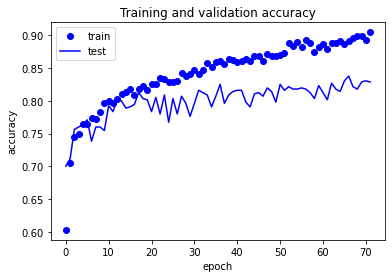

In [59]:
plt.plot(histories.history['accuracy'], 'bo')
plt.plot(histories.history['val_accuracy'],'b' )
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("accu.png", dpi=400)
plt.show()

Training and validation accuracy plot showes that almost after 75% accuracy (iteration 10), model starts to overfit becuase we can not see imporvment in test data prediction accuracy. 

Let's ealuate model performance with a dataset that have not seen yet (blind well).

In [45]:
result = model.evaluate(scaled_features_blind, labels_blind)

15/15 [==============================] - 0s 5ms/step - loss: 1.3078 - accuracy: 0.6285


In [46]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

accuracy: 62.85%


### Predict Blind Well Data and Plot

In [47]:
y_pred = model.predict(scaled_features_blind)
# result is probability array

In [48]:
y_pred_idx = np.argmax(y_pred, axis=1) + 1
# +1 becuase facies starts from 1 not zero like index

In [49]:
blind['Pred_Facies']= y_pred_idx

C:\Users\Alireza\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
def compare_facies_plot(logs, compadre, facies_colors):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='Depth')
    cmap_facies = colors.ListedColormap(
            facies_colors[0:len(facies_colors)], 'indexed')
    
    ztop=logs.Depth.min(); zbot=logs.Depth.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['Facies'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=7, figsize=(12, 6))
    ax[0].plot(logs.GR, logs.Depth, '-g', alpha=0.8, lw = 0.9)
    ax[1].plot(logs.ILD_log10, logs.Depth, '-b', alpha=0.8, lw = 0.9)
    ax[2].plot(logs.DeltaPHI, logs.Depth, '-k', alpha=0.8, lw = 0.9)
    ax[3].plot(logs.PHIND, logs.Depth, '-r', alpha=0.8, lw = 0.9)
    ax[4].plot(logs.PE, logs.Depth, '-c',  alpha=0.8, lw = 0.9)
    im1 = ax[5].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    im2 = ax[6].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies,vmin=1,vmax=9)
    
    divider = make_axes_locatable(ax[6])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((5*' ').join([' SS ', 'CSiS', 'FSiS', 
                                'SiSh', ' MS ', ' WS ', ' D  ', 
                                ' PS ', ' BS ']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(),logs.GR.max())
    ax[1].set_xlabel("ILD_log10")
    ax[1].set_xlim(logs.ILD_log10.min(),logs.ILD_log10.max())
    ax[2].set_xlabel("DeltaPHI")
    ax[2].set_xlim(logs.DeltaPHI.min(),logs.DeltaPHI.max())
    ax[3].set_xlabel("PHIND")
    ax[3].set_xlim(logs.PHIND.min(),logs.PHIND.max())
    ax[4].set_xlabel("PE")
    ax[4].set_xlim(logs.PE.min(),logs.PE.max())
    ax[5].set_xlabel('Facies')
    ax[6].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]); ax[5].set_yticklabels([]); ax[6].set_yticklabels([])
    ax[5].set_xticklabels([])
    ax[6].set_xticklabels([])
    f.suptitle('Well: %s'%logs.iloc[0]['Well Name'], fontsize=14,y=0.94)

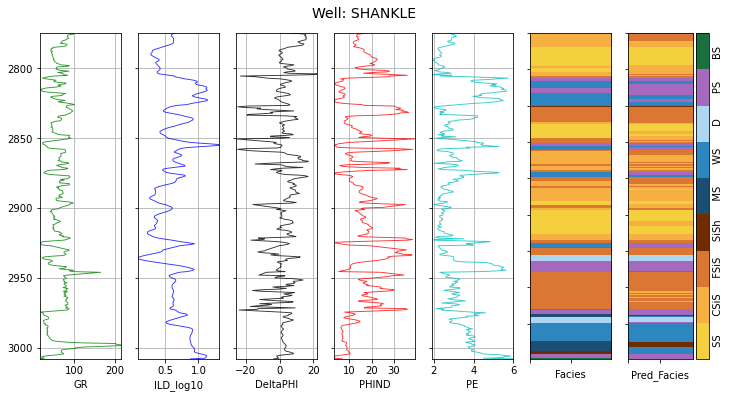

In [55]:
compare_facies_plot(blind, 'Pred_Facies', facies_colors)
plt.savefig("Compo.png", dpi=400)

### Conclusion

In this work, we optimized hyper-parameters using a Bayesian approach with scikit-learn library called skopt. This approach is superior to a random search and grid search, especially in complex datasets. Using this method, we can get rid of hand-tuning of hyper-parameters for the neural networks.

### References:
1. Havass-Labs [TensorFlow-Tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials)
2. [scikit-optimize](https://scikit-optimize.github.io/stable/)
